In [1]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.data as ds
import utils.model as model
import utils.training as training

In [2]:
# Load and generate datasets for biotac sensor classification
train_ds, val_ds, test_ds = ds.load_data("path_to_dataset/BioTac_slide_20_50/compiled_data/", 
                                        batch_size=40)

(600, 400, 19)
(200, 400, 19)
(600,)
(200,)
(200, 400, 19)
(200,)


In [3]:
## data format in batches
for v in train_ds.take(1):
    print(v)

(<tf.Tensor: shape=(40, 400, 19), dtype=float32, numpy=
array([[[48., 13., 14., ...,  6., 15., 18.],
        [53., 16., 16., ...,  7., 16., 21.],
        [57., 14., 16., ...,  4., 17., 21.],
        ...,
        [15.,  1.,  2., ...,  0.,  4.,  3.],
        [13.,  0.,  1., ...,  0.,  0.,  1.],
        [12.,  2.,  2., ...,  0.,  2.,  2.]],

       [[70., 17., 20., ...,  6., 19., 26.],
        [78., 16., 20., ...,  2., 18., 24.],
        [80., 15., 17., ...,  1., 19., 24.],
        ...,
        [17.,  2.,  2., ...,  0.,  2.,  3.],
        [14.,  3.,  3., ...,  1.,  1.,  1.],
        [11.,  1.,  1., ...,  0.,  1.,  4.]],

       [[45., 12., 12., ...,  6., 14., 18.],
        [52., 13., 15., ...,  7., 14., 18.],
        [51., 13., 14., ...,  7., 15., 20.],
        ...,
        [16.,  1.,  1., ...,  0.,  3.,  4.],
        [18.,  1.,  2., ...,  0.,  3.,  5.],
        [18.,  1.,  2., ...,  1.,  4.,  4.]],

       ...,

       [[39., 11., 10., ...,  7., 11., 16.],
        [42., 11., 11., ...,  4

In [4]:
### test model to check outputs with arbitrary input sequence length:
test = model.TransformerClassifier(1, 32, 4, 32, 400)
temp_input = tf.random.uniform((1,74,19), dtype=tf.float32, minval=0, maxval=200)
fn_out = test(temp_input, training=False,enc_padding_mask=None)
print(fn_out)

tf.Tensor(
[[0.04234074 0.02023327 0.0158552  0.03232373 0.06452919 0.02497124
  0.02578556 0.03560105 0.05556979 0.04188838 0.02689709 0.03278383
  0.21851975 0.03192272 0.02815823 0.09395786 0.05763071 0.04734688
  0.03811774 0.06556702]], shape=(1, 20), dtype=float32)


In [5]:
learning_rate = training.CustomSchedule(24, warmup_steps=400)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [6]:
## Have a play around with the model parameters
# Num_layers, d_model, attn_heads, ffn_depth, max_sequence_length:
transformer = model.TransformerClassifier(2, 24, 4, 64, 400)

In [9]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [10]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None, 19), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.float32),
]

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

@tf.function(input_signature=train_step_signature)
def train_step(inp_seq, material):
    

    with tf.GradientTape() as tape:
        predictions = transformer(inp_seq, True, None)
        loss = loss_object(material, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    return predictions, loss

In [11]:
num_epochs = 300

In [12]:
## TODO: Add validation metrics vis during training

for epoch in range(num_epochs):
    start = time.time()
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for (batch, (inp, tar)) in enumerate(train_ds):
        # train with random sequence length
        seq_length = tf.random.uniform(shape=[],minval=1, maxval=401, dtype=tf.int64) 
        predictions, loss = train_step(inp[:,0:seq_length,:], tar)
        epoch_loss_avg.update_state(loss)
        epoch_accuracy.update_state(tar, predictions)

    if (epoch+1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

        print(f'Epoch {epoch + 1} Loss {epoch_loss_avg.result():.4f} Accuracy {epoch_accuracy.result():.4f}')

        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 2.8057 Accuracy 0.1533
Time taken for 1 epoch: 0.17 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Loss 1.9480 Accuracy 0.3267
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Epoch 15 Loss 1.3192 Accuracy 0.5833
Time taken for 1 epoch: 0.18 secs

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Epoch 20 Loss 1.4419 Accuracy 0.5250
Time taken for 1 epoch: 0.17 secs

Saving checkpoint for epoch 25 at ./checkpoints/train/ckpt-5
Epoch 25 Loss 1.1397 Accuracy 0.6000
Time taken for 1 epoch: 0.19 secs

Saving checkpoint for epoch 30 at ./checkpoints/train/ckpt-6
Epoch 30 Loss 1.0728 Accuracy 0.6533
Time taken for 1 epoch: 0.18 secs

Saving checkpoint for epoch 35 at ./checkpoints/train/ckpt-7
Epoch 35 Loss 0.7988 Accuracy 0.7033
Time taken for 1 epoch: 0.18 secs

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-8
Epoch 40 L

In [13]:
## model summary and performance metrics on test dataset

transformer.summary()

test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
for (batch, (inp, tar)) in enumerate(test_ds):
        predictions = transformer(inp, False, None)
        test_accuracy.update_state(tar, predictions)
print(test_accuracy.result())

Model: "transformer_classifier_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  11792     
_________________________________________________________________
global_average_pooling1d_1 ( multiple                  0         
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dense_22 (Dense)             multiple                  800       
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
dense_23 (Dense)             multiple                  660       
Total params: 13,252
Trainable params: 13,252
Non-trainable params: 0
______________________________________

In [15]:
## generate accuracy over time for test dataset

sequential_accuracy = []
for i in range(1,400):
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    for (batch, (inp, tar)) in enumerate(test_ds):
        #print(inp[:,0:i])
        predictions = transformer(inp[:,0:i,:], False, None)
        test_accuracy.update_state(tar, predictions)
    #print(test_accuracy.result())
    sequential_accuracy.append(test_accuracy.result())

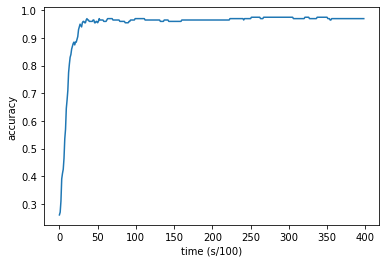

In [16]:
# Visualise the classification accuracy against input sequence length (time)
plt.plot(sequential_accuracy)
plt.ylabel("accuracy")
plt.xlabel("time (s/100)")

plt.show()